episode 100000.0
episode 200000.0
episode 300000.0
episode 400000.0
episode 500000.0
episode 600000.0
episode 700000.0
episode 800000.0
episode 900000.0
episode 1.0e6
episode 1.1e6
episode 1.2e6
episode 1.3e6
episode 1.4e6
episode 1.5e6
episode 1.6e6
episode 1.7e6
episode 1.8e6
episode 1.9e6
episode 2.0e6
episode 2.1e6
episode 2.2e6
episode 2.3e6
episode 2.4e6
episode 2.5e6
episode 2.6e6
episode 2.7e6
episode 2.8e6
episode 2.9e6
episode 3.0e6
episode 3.1e6
episode 3.2e6
episode 3.3e6
episode 3.4e6
episode 3.5e6
episode 3.6e6
episode 3.7e6
episode 3.8e6
episode 3.9e6
episode 4.0e6
episode 4.1e6
episode 4.2e6
episode 4.3e6
episode 4.4e6
episode 4.5e6
episode 4.6e6
episode 4.7e6
episode 4.8e6
episode 4.9e6
episode 5.0e6
episode 5.1e6
episode 5.2e6
episode 5.3e6
episode 5.4e6
episode 5.5e6
episode 5.6e6
episode 5.7e6
episode 5.8e6
episode 5.9e6
episode 6.0e6
episode 6.1e6
episode 6.2e6
episode 6.3e6
episode 6.4e6
episode 6.5e6
episode 6.6e6
episode 6.7e6
episode 6.8e6
episode 6.9e6
episode

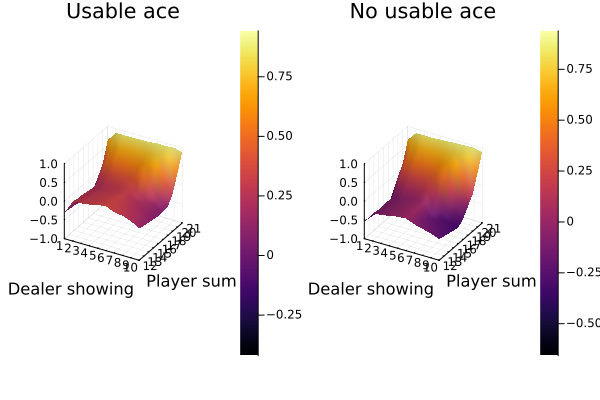

In [4]:
# solving the black jack game described in example 5.1
using Random, StatsBase

# the face values for a suit
# ace through nine, ten, jack, queen, king
# note that 1=ace
suit = vcat(1, collect(2:9), 10, 10, 10, 10)

# a deck of cards consists of four suits: diamonds, clubs, hearts, spades
deck = repeat(suit, 4)
shuffle!(deck)     # a random permutation

# to simulate an infinite deck, we can sample with replacement
deal_cards(n) = sample(deck, n, replace=true)

# note that it's quite possible (in fact it's common) to have more than
# one ace in a hand, but it's not possible to have two "usable" aces.
# 1/2 = no/yes
usable_ace(hand) = (any(hand .== 1) && sum(hand) <= 11) ? 2 : 1

score(hand) = sum(hand) + (usable_ace(hand)==2 ? 10 : 0)

# simulate an episode of blackjack according to policy π
function blackjack(π, ε = 0.05)
    player = deal_cards(2) #deal 2 cards to player
    dealer = deal_cards(2) #deal 2 to the dealer

    
    while score(player) < 12 #make sure the players hand is at least 12
        push!(player, deal_cards(1)[1]) #deal the player a card
    end

    states = [] #list of our states
    actions = [] #list of our actions

    if score(player) == 21  # check for player blackjack
        if score(dealer) == 21 #check for dealer blackjack
            return states, actions, 0.0 #reward 0 for a tie
        else
            return states, actions, 1.0 #dealer doesnt have 21, reward a win
        end
    end

    while true #start the turn
        player_sum = score(player) #total score of players hand
        dealer_card = dealer[1] #dealers card
        ace_status = usable_ace(player) #checks for a usable ace
        state = (player_sum - 11, dealer_card, ace_status) #adjusted sum, dealer card, usable ace
        push!(states, state) #log the current state of the game
        action = π[state...] #find the move based on the policy (hit or stay)
        
        if rand() < ε #choose a random action to explore
            action = 3 - action #switch between hitting and staying
        end
        push!(actions, action) #push our chosen action
        if action == 2  #stay
            break
        else  #hit
            push!(player, deal_cards(1)[1]) #add a card
            if score(player) > 21  #player busts
                return states, actions, -1.0 #return a loss
            end
        end
    end

    while score(dealer) < 17
        push!(dealer, deal_cards(1)[1])
    end #hit on the dealers hand up until they get 17

    player_final_score = score(player) 
    dealer_final_score = score(dealer) #store scores for dealer and player

    if dealer_final_score > 21 || player_final_score > dealer_final_score
        return states, actions, 1.0 #if the dealer busts or the player has a higher score at the end of the "turn", mark it as a win
    elseif player_final_score < dealer_final_score
        return states, actions, -1.0 #if the player score is lower than the dealer, record a player loss
    else
        return states, actions, 0.0 #record a push
    end
end


# this is on-policy every-visit MC control because we do not check for
# 1st visits to states; however, for the game of blackjack, it's not
# possible to visit the same state twice in an episode. you could have
# an ace being counted as 11, and then later being counted as 1, but
# the indicator for a usable ace is part of the state.  also, note
# that we maintain exploration of nonoptimal actions in the function
# blackjack().
function MC!(q, qn, π)
    for i = 1:10e6
        i % 100000 == 0 && println("episode ", i)
        states, actions, r = blackjack(π)
        @assert(length(states) == length(actions))
        @assert( r in [-1.0, 0.0, 1.0])
        T = length(states)
        for t = 1:T
            # since this is every-visit MC, the reward at the end
            # of the episode is the return for each state visited, and
            # there is no discounting, the direction of iteration over
            # the episode should not matter.
            
            # obtain the state s and action  a for play t
            s = states[t]
            a = actions[t]

            # Update qn
            qn[s..., a] += 1

            # Update q (incremental update)
            q[s..., a] += (r - q[s..., a]) / qn[s..., a]

            # Find the action that maximizes q for state s
            max_a = argmax(q[s..., :])

            # Update the policy
            π[s...] = max_a
        end
    end
end

# the state space consists of
# the player's sum 12:21,
# the dealer's showing card 1:10,
# and indicator for usable ace no/yes=1/2
# for a total of 200 possible states.
# the action is hit/stick=1/2

# the initial policy is to stick when the player's sum is 20 or 21, otherwise hit
π = fill(1, (10, 10, 2))
π[9:10,:,:] .= 2           # stick when sum is 20 or 21
q = zeros(10, 10, 2, 2)    # q(state=(player,dealer,usable), action)
qn = zeros(10, 10, 2, 2)   # to hold the number of observations

MC!(q, qn, π)

using Plots
player_string = [string(i) for i = 12:21]  
dealer_string = [string(i) for i = 1:10]

# julia stores matrices in column-major order
# note:
# x = [ 1 2 3; 4 5 6 ]
# x[:]
# is stored as 1 4 2 5 3 6

# plot the optimal policy
z = π[:,:,2]
pl1 = heatmap(dealer_string, player_string, z,
              aspect_ratio=1,
              xlabel="Dealer showing",
              ylabel="Player sum",
              title="Usable ace",
              fmt=:png)
z = π[:,:,1]
pl2 = heatmap(dealer_string, player_string, z,
              aspect_ratio=1,
              xlabel="Dealer showing",
              ylabel="Player sum",
              title="No usable ace",
              fmt=:png)
plot(pl1,pl2)
# obtain the state-value function v from the action-value function q
v = zeros(10, 10, 2)
for pl = 1:size(q)[1]
    for de = 1:size(q)[2]
        for us = 1:size(q)[3]
            v[pl,de,us] = findmax(q[pl,de,us,:])[1]
        end
    end
end
# plot the state-value function
pl3 = surface(dealer_string, player_string, v[:,:,2],
              xlabel = "Dealer showing",
              ylabel = "Player sum",
              title = "Usable ace",
              zlims = (-1.0,1.0))
pl4 = surface(dealer_string, player_string, v[:,:,1],
              xlabel = "Dealer showing",
              ylabel = "Player sum",
              title = "No usable ace",
              zlims = (-1.0,1.0))
plot(pl3,pl4)
